In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

import cartopy.crs as ccrs

import statsmodels

import os
from tqdm import tqdm, trange

from convertbng.util import convert_bng, convert_lonlat
import utm

In [2]:
# code and species dictionary

code_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Alberta/To_look_at/Banff_NP_Freshwater_Lake_Fish_Index_2017_data_dictionary.csv')
# code_df = code_df.iloc[:-6]
code_df.rename(columns={'Data_Value_Valeur_de_la_donnée': 'code_name', 
                        'Value_Description_EN_Description_de_la_valeur': 'common_name'}, inplace=True)
code_df = code_df[['code_name', 'common_name']]
code_df['common_name'] = code_df['common_name'].str.lower().str.replace(' ', '_')
display(code_df.sample(5))

dict_code_name = code_df.set_index('code_name').to_dict()['common_name']

,code_name,common_name
17,YSCT,yellowtone_cutthroat_trout
29,FTMN,fathead_minnow
46,TRPR,trout-perch
14,SPLK,splake
13,RNTR,rainbow_trout


In [3]:
new_codes = {'LNDC': 'longnose_dace', 'BNTR': 'brown_trout', 'RNTR1': 'rainbow_trout', 'CTTR1': 'cutthroat_trout', 
             'WHSC': 'white_sucker', 'BLTRCTTR(N&I)': 'bull_trout_x_cutthroat_trout', 'CTTR(hybrids)': 'cutthroat_trout', 
             'CTTRhybrids': 'cutthroat_trout', 'SUCK': 'white_sucker'}

dict_code_name.update(new_codes)

In [4]:
# Species dictionay

species_name_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name_dictionary.csv')

dict_species_name = species_name_df.set_index('common_name').to_dict()['scientific_name']

In [6]:
new_names = {'atlantic_silverside': 'menidia_menidia', 
             'nine_spine_stickleback': 'pungitius_pungitius', 'four_spine_stickleback': 'apeltes_quadracus', 
             'black_nose_dace': 'rhinichthys_atratulus', 'three-spine_stickleback': 'gasterosteus aculeatus', 
             'nine-spine_stickleback': 'pungitius_pungitius'}

dict_species_name.update(new_names)
dict_species_name

{'striped_bass': 'morone_saxatilis',
 'american_shad': 'alosa_sapidissima',
 'white_sucker': 'catostomus_commersonii',
 'channel_catfish': 'ictalurus_punctatus',
 'mooneye': 'hiodon_tergisus',
 'walleye': 'sander_vitreus',
 'lake_sturgeon': 'acipenser_fulvescens',
 'rainbow_smelt': 'osmerus_mordax',
 'longnose_sucker': 'catostomus_catostomus',
 'alewife': 'alosa_pseudoharengus',
 'american_eel': 'anguilla_rostrata',
 'white_perch': 'morone_americana',
 'quillback': 'carpiodes_cyprinus',
 'smallmouth_bass': 'micropterus_dolomieu',
 'silver_redhorse': 'moxostoma_anisurum',
 'logperch': 'percina_caprodes',
 'tessellated_darter': 'etheostoma_olmstedi',
 'brown_bullhead': 'ameiurus_nebulosus',
 'longnose_gar': 'lepisosteus_osseus',
 'freshwater_drum': 'aplodinotus_grunniens',
 'fallfish': 'semotilus_corporalis',
 'channel_darter': 'percina_copelandi',
 'emerald_shiner': 'notropis_atherinoides',
 'johnny_darter': 'etheostoma_nigrum',
 'tadpole_madtom': 'noturus_gyrinus',
 'trout-perch': 'per

In [96]:
species_name_df = pd.DataFrame.from_dict({'common_name': list(dict_species_name.keys()), 
                                        'scientific_name' : list(dict_species_name.values())})
# species_name_df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/species_name_dictionary.csv', index=False)

# Alberta

In [5]:
path = '/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/'

In [6]:
habitat_files = [file for file in os.listdir(path) if 'Habitat_AlyssaMurdoch_May2020' in file]

habitat_df = []

for file in tqdm(habitat_files):
    df = pd.read_csv(f'{path}{file}', engine='python', header=1)
    print(len(df))
    habitat_df.append(df)
    
habitat_df = pd.concat(habitat_df)
habitat_df['lat_long'] = habitat_df['Latitude'].round(3).astype(str) + '_' + habitat_df['Longitude'].round(3).astype(str)
print(len(habitat_df))
habitat_df.drop_duplicates(inplace=True)
print(len(habitat_df))

habitat_df = habitat_df[['Waterbody Official Name', 'Waterbody Common Name', 'lat_long', 'Start/Effective Date', 
                         'Water Temperature (C)', 'Water Conductivity (�S/cm)', 'Dissolved Oxygen (mg/L)', 'Water pH', 
                         'Water Bottom Depth (m)']]

habitat_df.replace('UNNAMED', np.nan, inplace=True)
habitat_df['Waterbody Official Name'] = np.where(habitat_df['Waterbody Official Name'].isna(), 
                                               habitat_df['Waterbody Common Name'], habitat_df['Waterbody Official Name'])

habitat_df['year'] = pd.DatetimeIndex(pd.to_datetime(habitat_df['Start/Effective Date'])).year
habitat_df.drop(columns=['Start/Effective Date', 'Waterbody Common Name'], inplace=True)

df_location = habitat_df[['Waterbody Official Name', 'lat_long']]
df_location.drop_duplicates(inplace=True)

habitat_df = habitat_df.groupby(['lat_long', 'year']).mean().reset_index()
print(len(habitat_df))
habitat_df.sample(5)

 50%|█████     | 2/4 [00:00<00:01,  1.95it/s]

33209
6389
249


100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

33137
72984


72984
7942


/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,lat_long,year,Water Temperature (C),Water Conductivity (�S/cm),Dissolved Oxygen (mg/L),Water pH,Water Bottom Depth (m)
3574,54.411_-111.018,1981,NaN,NaN,NaN,NaN,1.520000
6371,55.886_-119.229,2018,19.000000,NaN,NaN,NaN,3.700000
4860,55.007_-119.828,2009,16.000000,0.000000,NaN,NaN,0.372000
7216,56.923_-112.149,2015,6.666667,208.333333,11.566667,7.87,0.433333
2184,53.619_-113.298,2016,NaN,NaN,NaN,NaN,NaN


In [7]:
habitat_df = habitat_df.merge(df_location, on = 'lat_long', how='left')
print(len(habitat_df))
display(habitat_df)

7973


,lat_long,year,Water Temperature (C),Water Conductivity (�S/cm),Dissolved Oxygen (mg/L),Water pH,Water Bottom Depth (m),Waterbody Official Name
0,49.003_-110.611,1980,NaN,NaN,NaN,NaN,NaN,MILK RIVER
1,49.012_-113.457,2002,4.750000,NaN,9.600000,NaN,NaN,OUTPOST LAKE
2,49.016_-112.98,2014,11.300000,313.500000,8.770000,8.950000,30.000000,NORTH MILK RIVER
3,49.018_-112.982,1979,NaN,NaN,NaN,NaN,0.150000,NORTH MILK RIVER
4,49.01_-113.457,2016,4.403667,NaN,10.437333,NaN,NaN,OUTPOST LAKE
...,...,...,...,...,...,...,...,...
7968,59.939_-110.294,1974,11.875000,56.666667,6.333333,6.833333,NaN,BAYONET LAKE
7969,59.943_-111.007,1965,12.468421,NaN,NaN,7.400000,15.480789,LELAND LAKES
7970,59.94_-110.407,1974,12.000000,75.000000,7.000000,6.750000,NaN,TREASURE LOCH LAKE
7971,59.95_-111.0,1996,12.016667,60.000000,7.984167,8.400000,NaN,LELAND LAKES


In [8]:
habitat_df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/alberta_alyssa_habitat.csv', index=False)

### Species

In [9]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/TestNet_AlyssaMurdoch_May2020 (2).csv')
df = df[['Latitude', 'Longitude', 'Start/Effective Date', 'End/Termination Date', 'Species Common Name', 'Surface Area (ha)']]
df.dropna(inplace=True)

df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Start/Effective Date'])).year
df['Species Common Name'] = df['Species Common Name'].str.lower().str.rstrip().str.replace(' ', '_')
df['Species Common Name'].replace(dict_species_name, inplace=True)

df.drop(columns=['Start/Effective Date', 'End/Termination Date'], inplace=True)
df['lat_long'] = df['Latitude'].round(3).astype(str) + '_' + df['Longitude'].round(3).astype(str)
print(len(df))
display(df.sample(5))

155167


,Latitude,Longitude,Species Common Name,Surface Area (ha),year,lat_long
170284,55.901938,-115.718214,sander_vitreus,1222.8,2009,55.902_-115.718
183484,55.513862,-110.588112,sander_vitreus,12619.1,2011,55.514_-110.588
72588,54.812986,-112.002854,coregonus_artedi,23651.7,2007,54.813_-112.003
33383,54.641577,-111.655531,notropis_hudsonius,970.5,2015,54.642_-111.656
90848,55.340303,-115.589906,perca_flavescens,119267.0,1985,55.34_-115.59


In [10]:
for col in tqdm(df['Species Common Name'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

print(df['year'].min(), df['year'].max())
display(df.sample(5))

100%|██████████| 58/58 [01:03<00:00,  1.09s/it]

1942 2019


,Latitude,Longitude,Species Common Name,Surface Area (ha),year,lat_long,esox_lucius,catostomus_commersonii,salvelinus_confluentus,oncorhynchus_mykiss,...,etheostoma_exile,salmonidae_spp,sander_canadensis,triops,acipenser_fulvescens,carpiodes_cyprinus,ctenopharyngodon_idella,carassius_auratus,cyprinus_rubrofuscus,prosopium_coulterii
127056,52.089394,-113.446553,sander_vitreus,404.6,2019,52.089_-113.447,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103842,58.948071,-115.441188,catostomus_catostomus,7902.2,2009,58.948_-115.441,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17006,55.228175,-113.335844,sander_vitreus,13909.9,2009,55.228_-113.336,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17931,55.266157,-113.290077,sander_vitreus,13909.9,2012,55.266_-113.29,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64975,49.956684,-112.960600,coregonus_clupeaformis,2266.3,2009,49.957_-112.961,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(len(df))
df.drop(columns=['Species Common Name'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))
display(df.sample(5))

df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/alberta_occurence_1942_2019.csv', 
          index=False)

155167
13717


,Latitude,Longitude,Surface Area (ha),year,lat_long,esox_lucius,catostomus_commersonii,salvelinus_confluentus,oncorhynchus_mykiss,catostomus_catostomus,...,etheostoma_exile,salmonidae_spp,sander_canadensis,triops,acipenser_fulvescens,carpiodes_cyprinus,ctenopharyngodon_idella,carassius_auratus,cyprinus_rubrofuscus,prosopium_coulterii
150039,56.707902,-118.320105,51.0,2000,56.708_-118.32,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
694,52.300178,-116.349392,5204.1,2007,52.3_-116.349,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142465,55.122542,-116.778815,4211.6,1990,55.123_-116.779,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160482,57.173768,-112.655828,347.8,2008,57.174_-112.656,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179924,55.638581,-116.729461,4586.3,2006,55.639_-116.729,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merge Habitat and species

In [12]:
habitat_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/alberta_alyssa_habitat.csv')
print(len(habitat_df))
display(habitat_df.sample(5))

species_df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/alberta_occurence_1942_2019.csv')
print(len(species_df))
display(species_df.sample(5))

df_location = habitat_df[['lat_long', 'Waterbody Official Name']]

7973


,lat_long,year,Water Temperature (C),Water Conductivity (�S/cm),Dissolved Oxygen (mg/L),Water pH,Water Bottom Depth (m),Waterbody Official Name
4292,54.689_-110.957,1968,12.863158,NaN,3.9,7.95,13.395263,WOLF LAKE
7188,56.819_-111.405,2015,15.300000,286.6,9.9,8.20,1.900000,ATHABASCA RIVER
5506,55.352_-110.85,2010,7.700000,151.0,13.8,7.22,0.996667,NaN
1272,52.314_-114.105,2016,15.100000,812.0,6.6,8.43,NaN,SYLVAN LAKE
6929,56.511_-114.112,1996,15.000000,40.0,7.2,7.80,1.500000,NaN


13717


,Latitude,Longitude,Surface Area (ha),year,lat_long,esox_lucius,catostomus_commersonii,salvelinus_confluentus,oncorhynchus_mykiss,catostomus_catostomus,...,etheostoma_exile,salmonidae_spp,sander_canadensis,triops,acipenser_fulvescens,carpiodes_cyprinus,ctenopharyngodon_idella,carassius_auratus,cyprinus_rubrofuscus,prosopium_coulterii
6955,55.442420,-115.410572,119267.0,2001,55.442_-115.411,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10020,54.745604,-111.355369,3678.7,1965,54.746_-111.355,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5468,54.784331,-111.968010,23651.7,1993,54.784_-111.968,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9725,53.830888,-110.485874,107.1,2017,53.831_-110.486,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7528,56.054249,-115.807089,1177.3,2018,56.054_-115.807,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
species_location_df = species_df.merge(habitat_df, on=['lat_long', 'year'], how='left')
species_location_df = species_location_df.merge(df_location, on='lat_long', how='left')

species_location_df['waterbody_name'] = np.where(species_location_df['Waterbody Official Name_x'].isna(), 
                                                          species_location_df['Waterbody Official Name_y'], 
                                                          species_location_df['Waterbody Official Name_x'])
species_location_df.drop(columns=['Waterbody Official Name_x', 'Waterbody Official Name_y'], inplace=True)
species_location_df.dropna(subset=[col for col in species_location_df.columns if col in list(dict_species_name.values())], 
                           how='all', inplace=True)
print(len(species_location_df))
species_location_df.drop_duplicates(inplace=True)
print(len(species_location_df))
species_location_df.rename(columns = {'Latitude': 'latitude', 'Longitude': 'longitude', 
                                      'Waterbody Official Name': 'waterbody_name'}, inplace=True)

display(species_location_df.sample(5))

16325
13721


,latitude,longitude,Surface Area (ha),year,lat_long,esox_lucius,catostomus_commersonii,salvelinus_confluentus,oncorhynchus_mykiss,catostomus_catostomus,...,ctenopharyngodon_idella,carassius_auratus,cyprinus_rubrofuscus,prosopium_coulterii,Water Temperature (C),Water Conductivity (�S/cm),Dissolved Oxygen (mg/L),Water pH,Water Bottom Depth (m),waterbody_name
85,58.216209,-110.145554,522.4,1967,58.216_-110.146,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14280,54.100669,-112.150059,19.6,2014,54.101_-112.15,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11830,53.511792,-114.271923,27.0,2010,53.512_-114.272,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15209,59.021263,-114.480464,4726.1,2010,59.021_-114.48,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3503,54.202512,-111.717012,775.6,2013,54.203_-111.717,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
species_location_df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/alberta_location_occurence_1942_2019.csv', 
                           index=False)

# Manitoba

In [15]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Manitoba/Used/manitoba_anglers_stocking.csv')
print(len(df))
df = df[['WATERBODY_NAME', 'YEAR_', 'SPECIES', 'WATERBODY_LAT', 'WATERBODY_LONG']]

df['SPECIES'] = df['SPECIES'].str.lower().str.rstrip().str.replace(' ', '_')
df['SPECIES'].replace(dict_species_name, inplace=True)

df.rename(columns={'WATERBODY_LAT': 'latitude', 'WATERBODY_LONG': 'longitude', 'SPECIES': 'species', 'YEAR_': 'year'}, 
          inplace=True)
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['latitude'].round(3).astype(str)
df.columns = df.columns.str.lower()

df.drop_duplicates(inplace=True)
print(len(df))
display(df.head())

11768
9851


,waterbody_name,year,species,latitude,longitude,lat_long
0,WOODPECKERS POND R4,2020,oncorhynchus_mykiss,49.729755,-96.271489,49.73_49.73
1,LAC DU BONNET,2020,salmo_trutta,50.366597,-95.916676,50.367_50.367
3,LAC DU BONNET,2020,salmo_trutta_x_salvelinus_fontinalis,50.366597,-95.916676,50.367_50.367
5,LAC DU BONNET,2020,oncorhynchus_mykiss,50.366597,-95.916676,50.367_50.367
6,HUNT LAKE,2020,salvelinus_fontinalis,49.742504,-95.177395,49.743_49.743


In [16]:
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

print(df['year'].min(), df['year'].max())
display(df.sample(5))

100%|██████████| 27/27 [00:00<00:00, 49.41it/s]

1917 2020


,waterbody_name,year,species,latitude,longitude,lat_long,oncorhynchus_mykiss,salmo_trutta,salmo_trutta_x_salvelinus_fontinalis,salvelinus_fontinalis,...,sander_canadensis,ambloplites_rupestris,morone_chrysops,thymallus_arcticus,oncorhynchus_nerka,siluriformes_spp,oncorhynchus_clarkii,micropterus_salmoides,pimephales_promelas,chrosomus_neogaeus
10991,ROCK LAKE,1950,sander_vitreus,49.215828,-99.199997,49.216_49.216,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10457,DAUPHIN RIVER,1958,oncorhynchus_mykiss,51.959721,-98.065279,51.96_51.96,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10069,FALCON LAKE,1962,oncorhynchus_nerka,49.702868,-95.248326,49.703_49.703,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
9809,BEAUTIFUL LAKE,1965,esox_masquinongy,51.563593,-100.999715,51.564_51.564,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3267,WOODPECKERS POND R4,2004,oncorhynchus_mykiss,49.729755,-96.271489,49.73_49.73,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))
display(df.sample(5))

df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Processed/manitoba_anglers_stocking_occurence_1917_2020.csv', 
          index=False)

9851
8289


,waterbody_name,year,latitude,longitude,lat_long,oncorhynchus_mykiss,salmo_trutta,salmo_trutta_x_salvelinus_fontinalis,salvelinus_fontinalis,sander_vitreus,...,sander_canadensis,ambloplites_rupestris,morone_chrysops,thymallus_arcticus,oncorhynchus_nerka,siluriformes_spp,oncorhynchus_clarkii,micropterus_salmoides,pimephales_promelas,chrosomus_neogaeus
2417,SOUTH STEEPROCK LAKE,2008,52.556361,-101.420559,52.556_52.556,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2631,ROARING RIVER,2007,51.924850,-101.285710,51.925_51.925,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9161,PELICAN LAKE,1970,49.335828,-99.563611,49.336_49.336,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,IMRIE LAKE,2014,50.668056,-100.221939,50.668_50.668,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,VERRALL LAKE,2015,51.852491,-100.883336,51.852_51.852,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/Manitoba_fish_community_no_year.csv')

df.columns = df.columns.str.lower().str.rstrip().str.replace(' ', '_').str.replace('unid__', '', regex=True)
df.columns = df.columns.str.replace('_sp_', '_spp', regex=True).str.replace('__', '_', regex=True)

df.rename(columns={'diglat': 'latitude', 'diglong': 'longitude', 'waterbody': 'waterbody_name'}, inplace=True)
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['latitude'].round(3).astype(str)

df['year'] = -999

df.drop(columns=['test_species'], inplace=True)
df.rename(columns=dict_species_name, inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Processed/manitoba_no_year_no_lat_long.csv', index=False)

1001


,waterbody_name,lake_elev,max_depth,mean_depth,volume,surface_area_(ha),latitude,longitude,salvelinus_alpinus,thymallus_arcticus,...,ichthyomyzon_spp,stizostedion_spp,sander_vitreus,notropis_texanus,morone_chrysops,pomoxis_annularis,catostomus_commersonii,perca_flavescens,lat_long,year
796,LANGEN LAKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,nan_nan,-999
70,791,0.0,6.0,1.4,14.051,NaN,52.43639,-95.16778,0,0,...,0,0,1,0,0,0,1,1,52.436_52.436,-999
474,4588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,nan_nan,-999
986,WESK HAWK LAKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,1,0,nan_nan,-999
559,7152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,0,nan_nan,-999


# British Columbia

In [19]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/BC_compiled_no_year.csv')
df.dropna(subset=['UTM_EASTING', 'UTM_NORTHING'], inplace=True)
df['year'] = -999

df['latitude'], df['longitude'] = np.where(df['UTM Zone'] == 9, (utm.to_latlon(df['UTM_EASTING'], df['UTM_NORTHING'], 9, 'U')), 
                                           np.nan)
df['latitude'], df['longitude'] = np.where(df['UTM Zone'] == 10, (utm.to_latlon(df['UTM_EASTING'], df['UTM_NORTHING'], 10, 'U')), 
                                           (df['latitude'], df['longitude']))
df['latitude'], df['longitude'] = np.where(df['UTM Zone'] == 11, (utm.to_latlon(df['UTM_EASTING'], df['UTM_NORTHING'], 11, 'U')), 
                                           (df['latitude'], df['longitude']))
df.drop(columns=['UTM Zone', 'UTM_EASTING', 'UTM_NORTHING'], inplace=True)

df.columns = df.columns.str.lower().str.split('(').str[0].str.rstrip().str.replace(' ', '_').str.replace('__', '_', regex=True)
df.rename(columns=dict_species_name, inplace=True)

df.drop(columns=[col for col in df.columns if col in['no_fish_caught_(bc_lakes_pre-1996)', 'no_fish_caught_(fiss,_fdis)', 
                                                     'no_fish_in_waterbody', 'unidentified_species', 'inconnu', 'no_fish_caught',
                                                     'unidentifiable_trout_-_only_fry_<70mm_in_length',  
                                                     'waterbody_identifier']], inplace=True)

df = df.mean(axis=1, level=0)

for col in [col for col in df.columns if col in list(dict_species_name.values())]:
    df[col] = df[col].replace(0, np.nan)
    df[col] = np.where(df[col].notnull(), 1, np.nan)

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Processed/BC_compiled_no_year.csv', index=False)

,surface_area,depth_maximum,depth_mean,volume,ph_surface,tds_surface,secchi_disc_depth,alosa_sapidissima,salvelinus_confluentus,salvelinus_alpinus,...,cottus_rhotheus,percopsis_omiscomaycus,sander_vitreus,lampetra_richardsoni,acipenser_transmontanus,catostomus_commersonii,perca_flavescens,year,latitude,longitude
1439,25.40,3.2,1.3,330200.0,8.8,NaN,1.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,52.152138,-120.444191
1421,25.00,48.0,25.1,6274000.0,6.5,18.0,8.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,53.321552,-121.344690
3745,NaN,7.7,NaN,NaN,NaN,256.0,4.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,57.612790,-121.340357
2222,68.25,15.2,3.3,2139942.0,8.0,90.0,3.8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,59.833118,-129.709306
1659,32.40,13.7,5.0,NaN,7.6,120.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999.0,51.453268,-119.779225


## Quebec

In [20]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/Quebec_Bertolo_Magnan_2006.csv')
df['year'] = 2006
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df.columns = df.columns.str.lower().str.rstrip().str.replace(' ', '_')
df.rename(columns=dict_species_name, inplace=True)

for col in [col for col in df.columns if col in list(dict_species_name.values())]:
    df[col] = df[col].replace(0, np.nan)
    df[col] = np.where(df[col].notnull(), 1, np.nan)

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Processed/quebec_bertolo_2006.csv', index=False)

,waterbody_name,latitude,longitude,surface_area_(ha),catostomus_commersonii,esox_lucius,perca_flavescens,coregonus_clupeaformis,semotilus_corporalis,sander_vitreus,...,notropis_hudsonius,pungitius_pungitius,percopsis_omiscomaycus,perca_flavescens,notropis_heterolepis,luxilus_cornutus,culaea_inconstans,cyprinidae_spp,year,lat_long
2,C23,48.8469,-76.0133,28.81,NaN,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,48.847_-76.013
0,C12,48.3469,-74.5367,34.75,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2006,48.347_-74.537
15,FP30,48.0375,-74.9500,33.89,1.0,1.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2006,48.038_-74.95
27,N56,48.0000,-75.4111,27.22,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,48.0_-75.411
7,C48,48.8319,-73.3203,231.10,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,48.832_-73.32


## New Brunswick

In [21]:
df = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Used/New_Brunswick_Hansen 2004.csv')
df['year'] = 2004
df['lat_long'] = df['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)
df.columns = df.columns.str.lower().str.rstrip().str.replace(' ', '_')
df.rename(columns=dict_species_name, inplace=True)

for col in [col for col in df.columns if col in list(dict_species_name.values())]:
    df[col] = df[col].replace(0, np.nan)
    df[col] = np.where(df[col].notnull(), 1, np.nan)

display(df.sample(5))
df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Processed/new_brunswick_hansen_2004.csv', index=False)

,waterbody_name,latitude,longitude,area_(ha),maximum_depth_(m),salmo_salar,ameiurus_nebulosus,fundulus_diaphanus,salvelinus_fontinalis,semotilus_atromaculatus,luxilus_cornutus,leuciscus_leuciscus,anguilla_rostrata,semotilus_corporalis,notemigonus_crysoleucas,couesius_plumbeus,salvelinus_namaycush,pungitius_pungitius,year,lat_long
13,Clear,45.233,-66.700,86.2,29.6,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,2004,45.233_-66.7
16,West Long,45.349,-66.659,254.3,17.4,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,2004,45.349_-66.659
17,South Oromocto,45.425,-66.658,951.7,6.4,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,2004,45.425_-66.658
6,A (McCready),45.401,-66.558,33.2,2.7,NaN,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,2004,45.401_-66.558
0,Cranberry (Tomoowa),45.363,-66.629,15.9,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,2004,45.363_-66.629


## River something
### RivFIshTime

In [24]:
df_location = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/DATABASE/RivFishTIME_TimeseriesTable.csv')

df_location = df_location[['TimeSeriesID', 'latitude', 'longitude', 'HydroBasin']]
df_location['site_description'] = 'river'

df_location['lat_long'] = df_location['latitude'].round(3).astype(str) + '_' + df['longitude'].round(3).astype(str)

df_location.drop_duplicates(inplace=True)
print(len(df_location))
display(df_location.sample(5))

11468


,TimeSeriesID,latitude,longitude,HydroBasin,site_description,lat_long
599,G10543,57.13323,12.298920,2080033130,river,NaN
3034,G1626,45.87264,-94.146070,7080047060,river,NaN
7076,G5315,51.23994,0.969461,2080053850,river,NaN
6084,G4416,50.73454,-4.063198,2080049450,river,NaN
2619,G13135,50.99900,4.586120,2080022770,river,NaN


In [25]:
df_survey = pd.read_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/DATABASE/RivFishTIME_SurveyTable.csv')

df_survey = df_survey[['TimeSeriesID', 'Year', 'Species']]
df_survey['Species'] = df_survey['Species'].str.lower().str.rstrip().str.replace(' ', '_')
df_survey.drop_duplicates(inplace=True)
print(len(df_survey))
df_survey.head()

583065


,TimeSeriesID,Year,Species
0,G51,2003,cyprinus_carpio
1,G1,2003,barbus_haasi
2,G1,2003,salmo_trutta
3,G23,2016,barbus_meridionalis
4,G23,2016,salmo_trutta


In [26]:
df = df_survey.merge(df_location, how='left')
df.drop(columns=['TimeSeriesID'], inplace=True)
print(len(df))
df['Species'].replace(dict_species_name, inplace=True)
df.drop_duplicates(inplace=True)
df = df.loc[(df['latitude'] > 12) & (df['longitude'] < -30)]
df.columns = df.columns.str.lower()
print(len(df))

display(df.sample(5))

583065
124346


,year,species,latitude,longitude,hydrobasin,site_description,lat_long
478849,2014,neogobius_melanostomus,43.77700,-79.16300,7080034520,river,NaN
51637,2003,etheostoma_flabellare,42.90273,-93.26263,7080047060,river,NaN
108947,2008,lepisosteus_osseus,38.87213,-90.17989,7080047060,river,NaN
140170,2012,cyprinella_spiloptera,46.65651,-93.97946,7080047060,river,NaN
114386,2011,lepomis_auritus,35.14137,-83.29577,7080047060,river,NaN


In [27]:
for col in tqdm(df['species'].unique()):
    df[col] = np.where(df.isin([col]).any(1), 1, np.nan)
    df[col] = df[col].fillna(df.groupby(['year', 'lat_long'])[col].transform('mean'))

print(df['year'].min(), df['year'].max())
display(df.sample(5))

100%|██████████| 453/453 [48:15<00:00,  6.39s/it]

1953 2019


,year,species,latitude,longitude,hydrobasin,site_description,lat_long,ambloplites_rupestris,campostoma_anomalum,catostomus_commersonii,...,oreochromis_aureus,cyprinodon_pecosensis,lucania_parva,notropis_jemezanus,rutilus_rutilus,margariscus_nachtriebi,campostoma_ornatum,notropis_braytoni,hybognathus_amarus,notropis_chihuahua
472037,2013,hybognathus_placitus,33.86046,-104.27550,7080049270,river,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59127,1974,campostoma_anomalum,34.63734,-94.65362,7080047060,river,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298564,2013,etheostoma_olmstedi,36.02979,-79.71919,7080042940,river,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150376,1994,lepomis_macrochirus,36.45444,-93.35611,7080047060,river,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293315,2006,etheostoma_flabellare,35.32611,-80.77361,7080043090,river,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
print(len(df))
df.drop(columns=['species'], inplace=True)
df.drop_duplicates(inplace=True)
print(len(df))
display(df.sample(5))

df.to_csv('/mnt/c/Users/imrit/Downloads/Sharma_fish_project/Sapna/Processed/riverfish_occurence_1953_2019.csv', 
          index=False)

139907
9245


,year,latitude,longitude,lat_long,ambloplites_rupestris,campostoma_anomalum,catostomus_commersonii,cyprinella_spiloptera,cyprinus_carpio,ericymba_buccata,...,oreochromis_aureus,cyprinodon_pecosensis,lucania_parva,notropis_jemezanus,rutilus_rutilus,margariscus_nachtriebi,campostoma_ornatum,notropis_braytoni,hybognathus_amarus,notropis_chihuahua
284075,2007,35.60552,-82.11167,35.606_-86.928,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43604,2000,42.53582,-93.78792,42.536_-86.935,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153694,1997,43.68488,-116.57374,43.685_17.413,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299039,2006,35.08861,-79.83528,35.089_-86.935,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137483,2007,45.54603,-95.87208,45.546_17.23,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


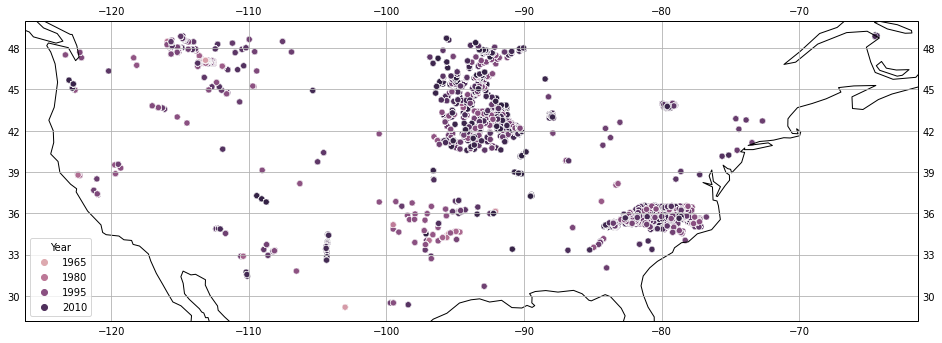

In [264]:
graph.figure(figsize=(16,9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

sns.scatterplot(df['longitude'], df['latitude'], transform=ccrs.PlateCarree(), hue=df['Year'])

graph.show()

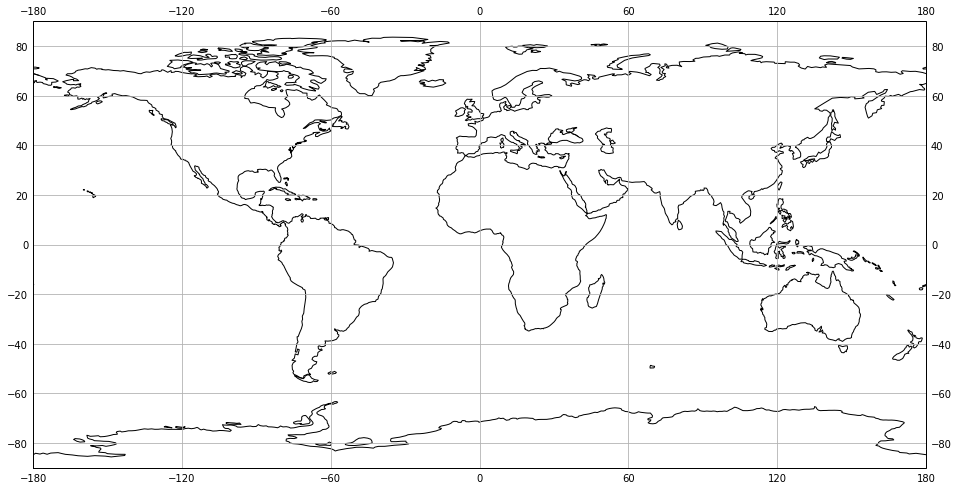

In [257]:
graph.figure(figsize=(16,9))
ax = graph.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)